In [ ]:
%%capture

!pip install gdown skyfield fastkml

In [ ]:
%%capture

import gdown

URL = 'https://drive.google.com/file/d/1uOjiwQXoqzyifkZirYmfzX1d_VSB0tDO/view?usp=sharing'
gdown.download(URL, 'original.jpg', quiet=True, fuzzy=True)

In [ ]:
%%capture

import gdown

URL = 'https://drive.google.com/file/d/1bU8aUNz8l_R5CkFO96m2IzYNqP7Fvhwf/view?usp=sharing'
gdown.download(URL, 'stars_marked.jpg', quiet=True, fuzzy=True)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_images(path1, path2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    img1 = mpimg.imread(path1)
    ax1.imshow(img1)
    ax1.axis('off')

    img2 = mpimg.imread(path2)
    ax2.imshow(img2)
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

show_images('original.jpg', 'stars_marked.jpg')

In [ ]:
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS

def get_gps_info(image_path):
    with Image.open(image_path) as img:
        exif_data = img._getexif()
        if not exif_data:
            return None

        exif = {
            TAGS.get(tag, tag): value
            for tag, value in exif_data.items()
            if tag in TAGS
        }

        gps_info = {}
        if 'GPSInfo' in exif:
            for idx, tag_name in GPSTAGS.items():
                tag_val = exif['GPSInfo'].get(idx)
                if tag_val:
                    gps_info[tag_name] = tag_val

        return gps_info

def get_location(gps_info):
  lat = (
      gps_info.get('GPSLatitude'),
      gps_info.get('GPSLatitudeRef')
  )
  lon = (
      gps_info.get('GPSLongitude'),
      gps_info.get('GPSLongitudeRef')
  )

  lat_degrees = lat[0][0]
  lat_minutes = lat[0][1]
  lat_seconds = lat[0][2]
  lat_direction = lat[1]

  lon_degrees = lon[0][0]
  lon_minutes = lon[0][1]
  lon_seconds = lon[0][2]
  lon_direction = lon[1]

  lat_decimal = lat_degrees + lat_minutes/60 + lat_seconds/3600
  if lat_direction == 'S':
      lat_decimal = -lat_decimal

  lon_decimal = lon_degrees + lon_minutes/60 + lon_seconds/3600
  if lon_direction == 'W':
      lon_decimal = -lon_decimal

  return (
      float(lat_decimal),
      float(lon_decimal),
  )

gps_info = get_gps_info('original.jpg')
my_location = get_location(gps_info)

my_location

In [ ]:
import pytz
from datetime import datetime

def get_timestamp(image_path):
    with Image.open(image_path) as img:
        exif_data = img._getexif()
        if exif_data:
            for tag_id, value in exif_data.items():
                tag = TAGS.get(tag_id, tag_id)
                if tag == 'DateTimeOriginal':
                    dt = datetime.strptime(value, '%Y:%m:%d %H:%M:%S')

                    local_tz = pytz.timezone('Asia/Ho_Chi_Minh')
                    local_dt = local_tz.localize(dt)

                    utc_dt = local_dt.astimezone(pytz.utc)
                    return utc_dt
    return None

photo_dt = get_timestamp('original.jpg')
photo_dt

In [ ]:
def get_exif(image_path):
    with Image.open(image_path) as img:
        exif_data = img._getexif()
        if not exif_data:
            return None

        exif = {
            TAGS.get(tag, tag): value
            for tag, value in exif_data.items()
            if tag in TAGS
        }

        return exif

get_exif('original.jpg')

This tells me that this was taken with default zoom:

'LensModel': 'Pixel 6a back camera 4.38mm f/1.73'

Ultra-wide zoom would have:

'LensModel': 'Pixel 6a back camera 2.35mm f/2.2'

For default zoom FOV is 48.96

'I can see 11cm of the rule from the distance of 12cm. Calculate angle of the the field of view for my phone camera'

For ultra wide FOV is 78.69

'I can see 24.5cm of the rule from the distance of 15cm. Calculate angle of the the field of view for my phone camera'

We can comfirm ultra wide FOV from Pixel specs https://www.dxomark.com/google-pixel-6a-camera-test/:

'Primary:12.2 MP 1/2.55″ sensor, 1.4 μm pixels, 77° field of view, f/1.7 aperture lens'

In [ ]:
HORIZONTAL_ANGLE = 48.96
HORIZONTAL_ANGLE

Take the side of the building we see and use to estimate direction we are looking at:

In [ ]:
from pyproj import Geod

geod = Geod(ellps='WGS84')

lat1, lon1 = my_location
lat2, lon2 = 20.9942647, 105.8689324

fwd_aimuth, _, _ = geod.inv(lon1, lat1, lon2, lat2)

# Print the forward azimuth
print(f"Forward azimuth: {fwd_aimuth:.2f} degrees")

In [ ]:
DIRECTION = fwd_aimuth + HORIZONTAL_ANGLE / 2.0
DIRECTION

In [ ]:
HORIZONTAL_LEFT_CUTOFF = DIRECTION - HORIZONTAL_ANGLE / 2.0
HORIZONTAL_LEFT_CUTOFF

In [ ]:
HORIZONTAL_RIGHT_CUTOFF = DIRECTION + HORIZONTAL_ANGLE / 2.0
HORIZONTAL_RIGHT_CUTOFF

The phone pitch is approximately 48 degrees:

In [ ]:
PHONE_PITCH = 48

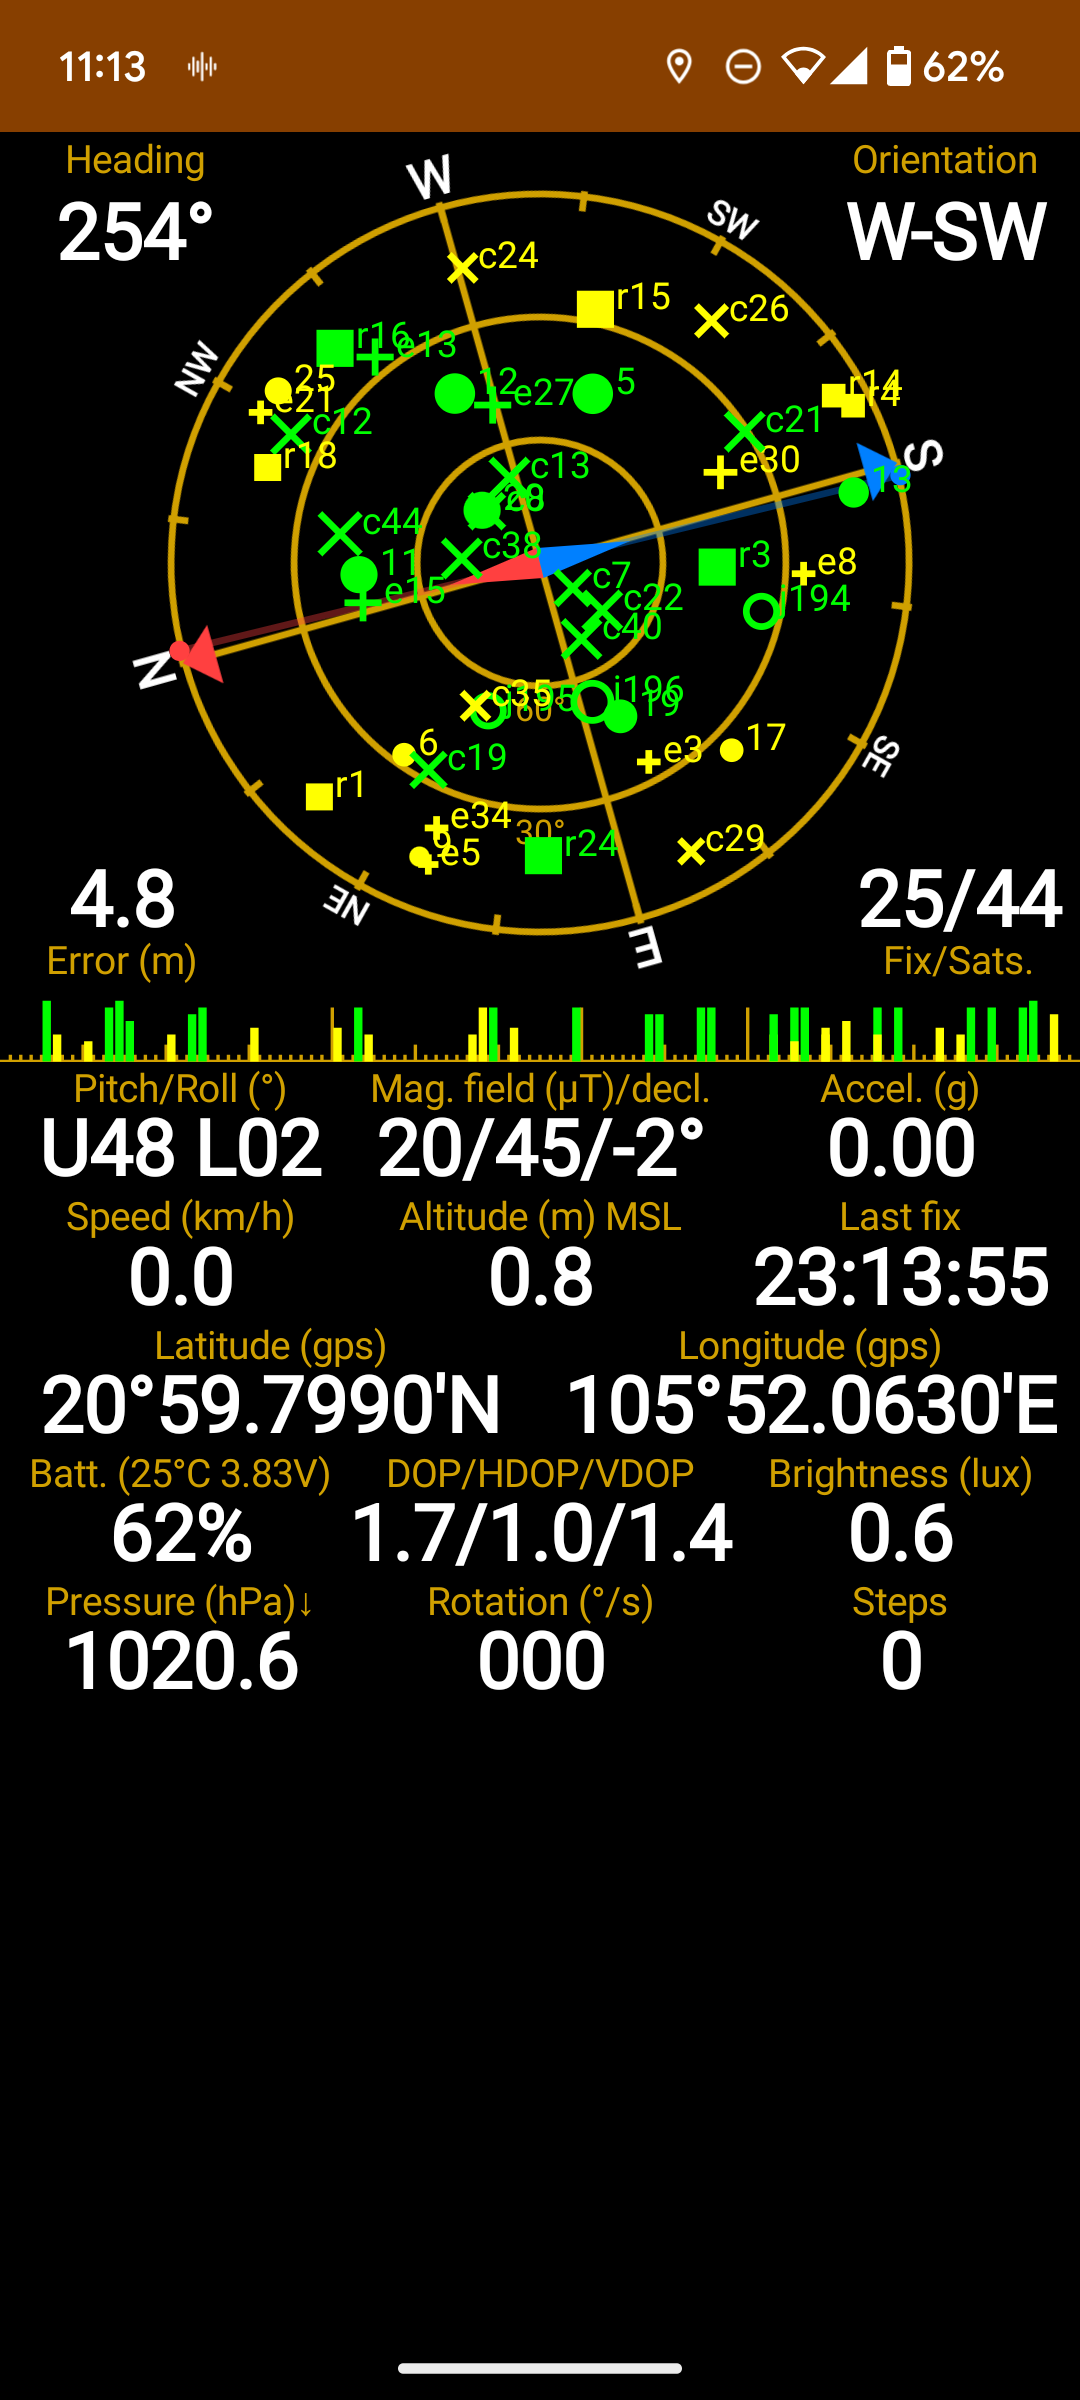

I do not know what is the vertical field of view for Pixel 6a. Horizomtal FOV is 77 degrees https://www.dxomark.com/google-pixel-6a-camera-test/ Based viewing ruler from the camera, I get vertical FOV to be 63.24 degrees https://x.com/i/grok/share/KZiI3RJkg8VP6Vx2CVxt53ax3



In [ ]:
VERTICAL_FOV = 63.24

In [ ]:
VERTICAL_TOP_CUTOFF = VERTICAL_FOV / 2 + PHONE_PITCH
VERTICAL_TOP_CUTOFF

In [ ]:
VERTICAL_BOTTOM_CUTOFF = abs(VERTICAL_FOV / 2 - PHONE_PITCH)
VERTICAL_BOTTOM_CUTOFF

In [ ]:
import math

def get_angle(height, distance):
    tangent = height / distance
    angle_radians = math.atan(tangent)
    return math.degrees(angle_radians)

# Approximate. Based on Google's Open Buildings dataset
BUILDING_HEIGHT = 70.106766
# Distance from where I am standing to the building
DISTANCE_TO_BUILDING = 147

BUILDING_CUTOFF_ANGLE = get_angle(BUILDING_HEIGHT, DISTANCE_TO_BUILDING)
BUILDING_CUTOFF_ANGLE

Since we have pitched the phone, the actual cutoff angle will be the building angle minus the angle of the camera:

In [ ]:
ACTUAL_VERTICAL_BOTTOM_CUTOFF = BUILDING_CUTOFF_ANGLE - VERTICAL_BOTTOM_CUTOFF
ACTUAL_VERTICAL_BOTTOM_CUTOFF

In [ ]:
%%capture

import gdown

URL = 'https://drive.google.com/file/d/1LtZqSzPvtkDZNswYLk999i7hWgG5HhrI/view?usp=sharing'
gdown.download(URL, 'star_names.csv', quiet=True, fuzzy=True)

In [ ]:
import pandas as pd

from skyfield.data import hipparcos
from skyfield.api import load

hipparcos_df = hipparcos.load_dataframe(load.open(hipparcos.URL))
star_df = pd.read_csv('star_names.csv')

df = pd.merge(hipparcos_df, star_df, left_on='hip', right_on='hip_id', how='outer')
df.shape

In [ ]:
named_stars_df = df[df['name'].notna()]
named_stars_df.shape

In [ ]:
# 4.9 and above should be visible https://medium.com/@cellphoneastronomy/astronomy-with-a-cellphone-how-low-faint-can-you-go-507803573fcf
brigher_stars_df = named_stars_df[named_stars_df['magnitude'] <= 4.9]
brigher_stars_df.shape

In [ ]:
import pprint
from skyfield.api import load, wgs84, Topos, Star

def is_within_fov(az, angle1, angle2):
    if angle1 > angle2:
        angle1, angle2 = angle2, angle1

    if angle1 <= az.degrees <= angle2:
        return True

    if angle2 - angle1 > 180:
        return angle2 <= az.degrees <= angle1 + 360 or 0 <= az.degrees <= angle2

def is_visible(position, vertical_top, vertical_bottom, horizontal_left, horizontal_right):
  alt, az, _ = position

  if alt.degrees < vertical_bottom or alt.degrees > vertical_top:
    return (False, 'Outside vertical field of view')

  within_fov = is_within_fov(az, horizontal_left, horizontal_right)
  if not within_fov:
    return (False, 'Outside horizontal field of view')

  return (True, None)

lat, lon = my_location

location = Topos(
    latitude_degrees=lat,
    longitude_degrees=lon,
    elevation_m=0,
)

EPH = load('de421.bsp')
observer = EPH['earth'] + location

ts = load.timescale()
t = ts.from_datetime(photo_dt)

stars = {}

for index, star_data in brigher_stars_df.iterrows():
  star_name = star_data['name'] if not pd.isna(star_data['name']) else star_data['hip_id']

  star = Star.from_dataframe(star_data)
  astrometric = observer.at(t).observe(star)
  position = astrometric.apparent().altaz()

  is_star_visible, _ = is_visible(
      position,
      VERTICAL_TOP_CUTOFF,
      ACTUAL_VERTICAL_BOTTOM_CUTOFF,
      HORIZONTAL_LEFT_CUTOFF,
      HORIZONTAL_RIGHT_CUTOFF,
  )
  if is_star_visible:
    alt, az, _ = position

    stars[star_name] = {
        'azimuth': az.degrees,
        'altitude': alt.degrees,
        'magnitude': star_data['magnitude'],
    }

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(stars)

In [ ]:
import numpy as np
from matplotlib import colormaps

def plot_all_stars(stars):
    plt.style.use('dark_background')
    plt.figure(figsize=(10, 6), dpi=300)

    colors = colormaps['tab10'](np.linspace(0, 1, len(stars)))
    for idx, (star_name, observation) in enumerate(stars.items()):
        plt.scatter(observation['azimuth'], observation['altitude'], color=colors[idx], s=20, label=star_name.capitalize())

    plt.xlabel("Azimuth (°)")
    plt.ylabel("Altitude (°)")
    plt.xlim((HORIZONTAL_LEFT_CUTOFF, HORIZONTAL_RIGHT_CUTOFF))
    plt.ylim((VERTICAL_BOTTOM_CUTOFF, VERTICAL_TOP_CUTOFF))
    plt.ylim(0, 90)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper right', fontsize='small', bbox_to_anchor=(1.2, 1))
    plt.show()

plot_all_stars(stars)

In [ ]:
from IPython.display import Markdown

STELLARIUM_SCRIPT = """
core.clear("natural");
core.setGuiVisible(false);

LandscapeMgr.setFlagAtmosphere(false);

SolarSystem.setFlagLabels(true);
SolarSystem.setLabelsAmount(10);

SolarSystem.setMoonScale(20);
SolarSystem.setFlagMoonScale(false);

SolarSystem.setFlagMinorBodyScale(false);
SolarSystem.setMinorBodyScale(20);

SolarSystem.setFlagPlanetScale(false);
SolarSystem.setPlanetScale(20);

StarMgr.setFlagStars(true);
StarMgr.setFlagLabels(true);

MilkyWay.setFlagShow(true);

ConstellationMgr.setFlagLabels(true);
ConstellationMgr.setFlagLines(true);

core.setObserverLocation(
    $LON$,
    $LAT$,
    $ALTITUDE$,
);

StelMovementMgr.zoomTo($FOV$, 0)
StelMovementMgr.moveViewport(0, -30, 0)

core.moveToAltAzi($EVENT_ALTITUDE$, $AZIMUTH$)
core.wait(0.01);

core.setDate("$DATE$", "local");
core.wait(5);

core.screenshot(
    "$SCREENSHOT_FILENAME$",
    false,
    "$SCREENSHOT_DIR$",
    true,
    "jpeg"
);

core.quitStellarium();
"""

def get_stellarium_date(image_path):
    with Image.open(image_path) as img:
        exif_data = img._getexif()
        if exif_data:
            for tag_id, value in exif_data.items():
                tag = TAGS.get(tag_id, tag_id)
                if tag == 'DateTimeOriginal':
                    dt = datetime.strptime(value, '%Y:%m:%d %H:%M:%S')
                    # Format as ISO 8601
                    return dt.strftime('%Y-%m-%dT%H:%M:%S')
    return None

date = get_stellarium_date('original.jpg')
lat, lon = my_location

az = DIRECTION
event_altitude = VERTICAL_TOP_CUTOFF / 2.0
fov = HORIZONTAL_ANGLE

script = STELLARIUM_SCRIPT\
    .replace("$DATE$", date)\
    .replace("$LAT$", str(lat))\
    .replace("$LON$", str(lon))\
    .replace("$ALTITUDE$", str(0))\
    .replace("$AZIMUTH$", str(az))\
    .replace("$EVENT_ALTITUDE$", str(event_altitude))\
    .replace("$FOV$", str(fov))\
    .replace("$SCREENSHOT_FILENAME$", "stellarium")\
    .replace("$SCREENSHOT_DIR$", "/Users/zhenya/Downloads")

Markdown(f"```\n{script}\n```")

Run script:

```
/Applications/Stellarium.app/Contents/MacOS/stellarium --startup-script /Users/zhenya/Downloads/script.ssc
```

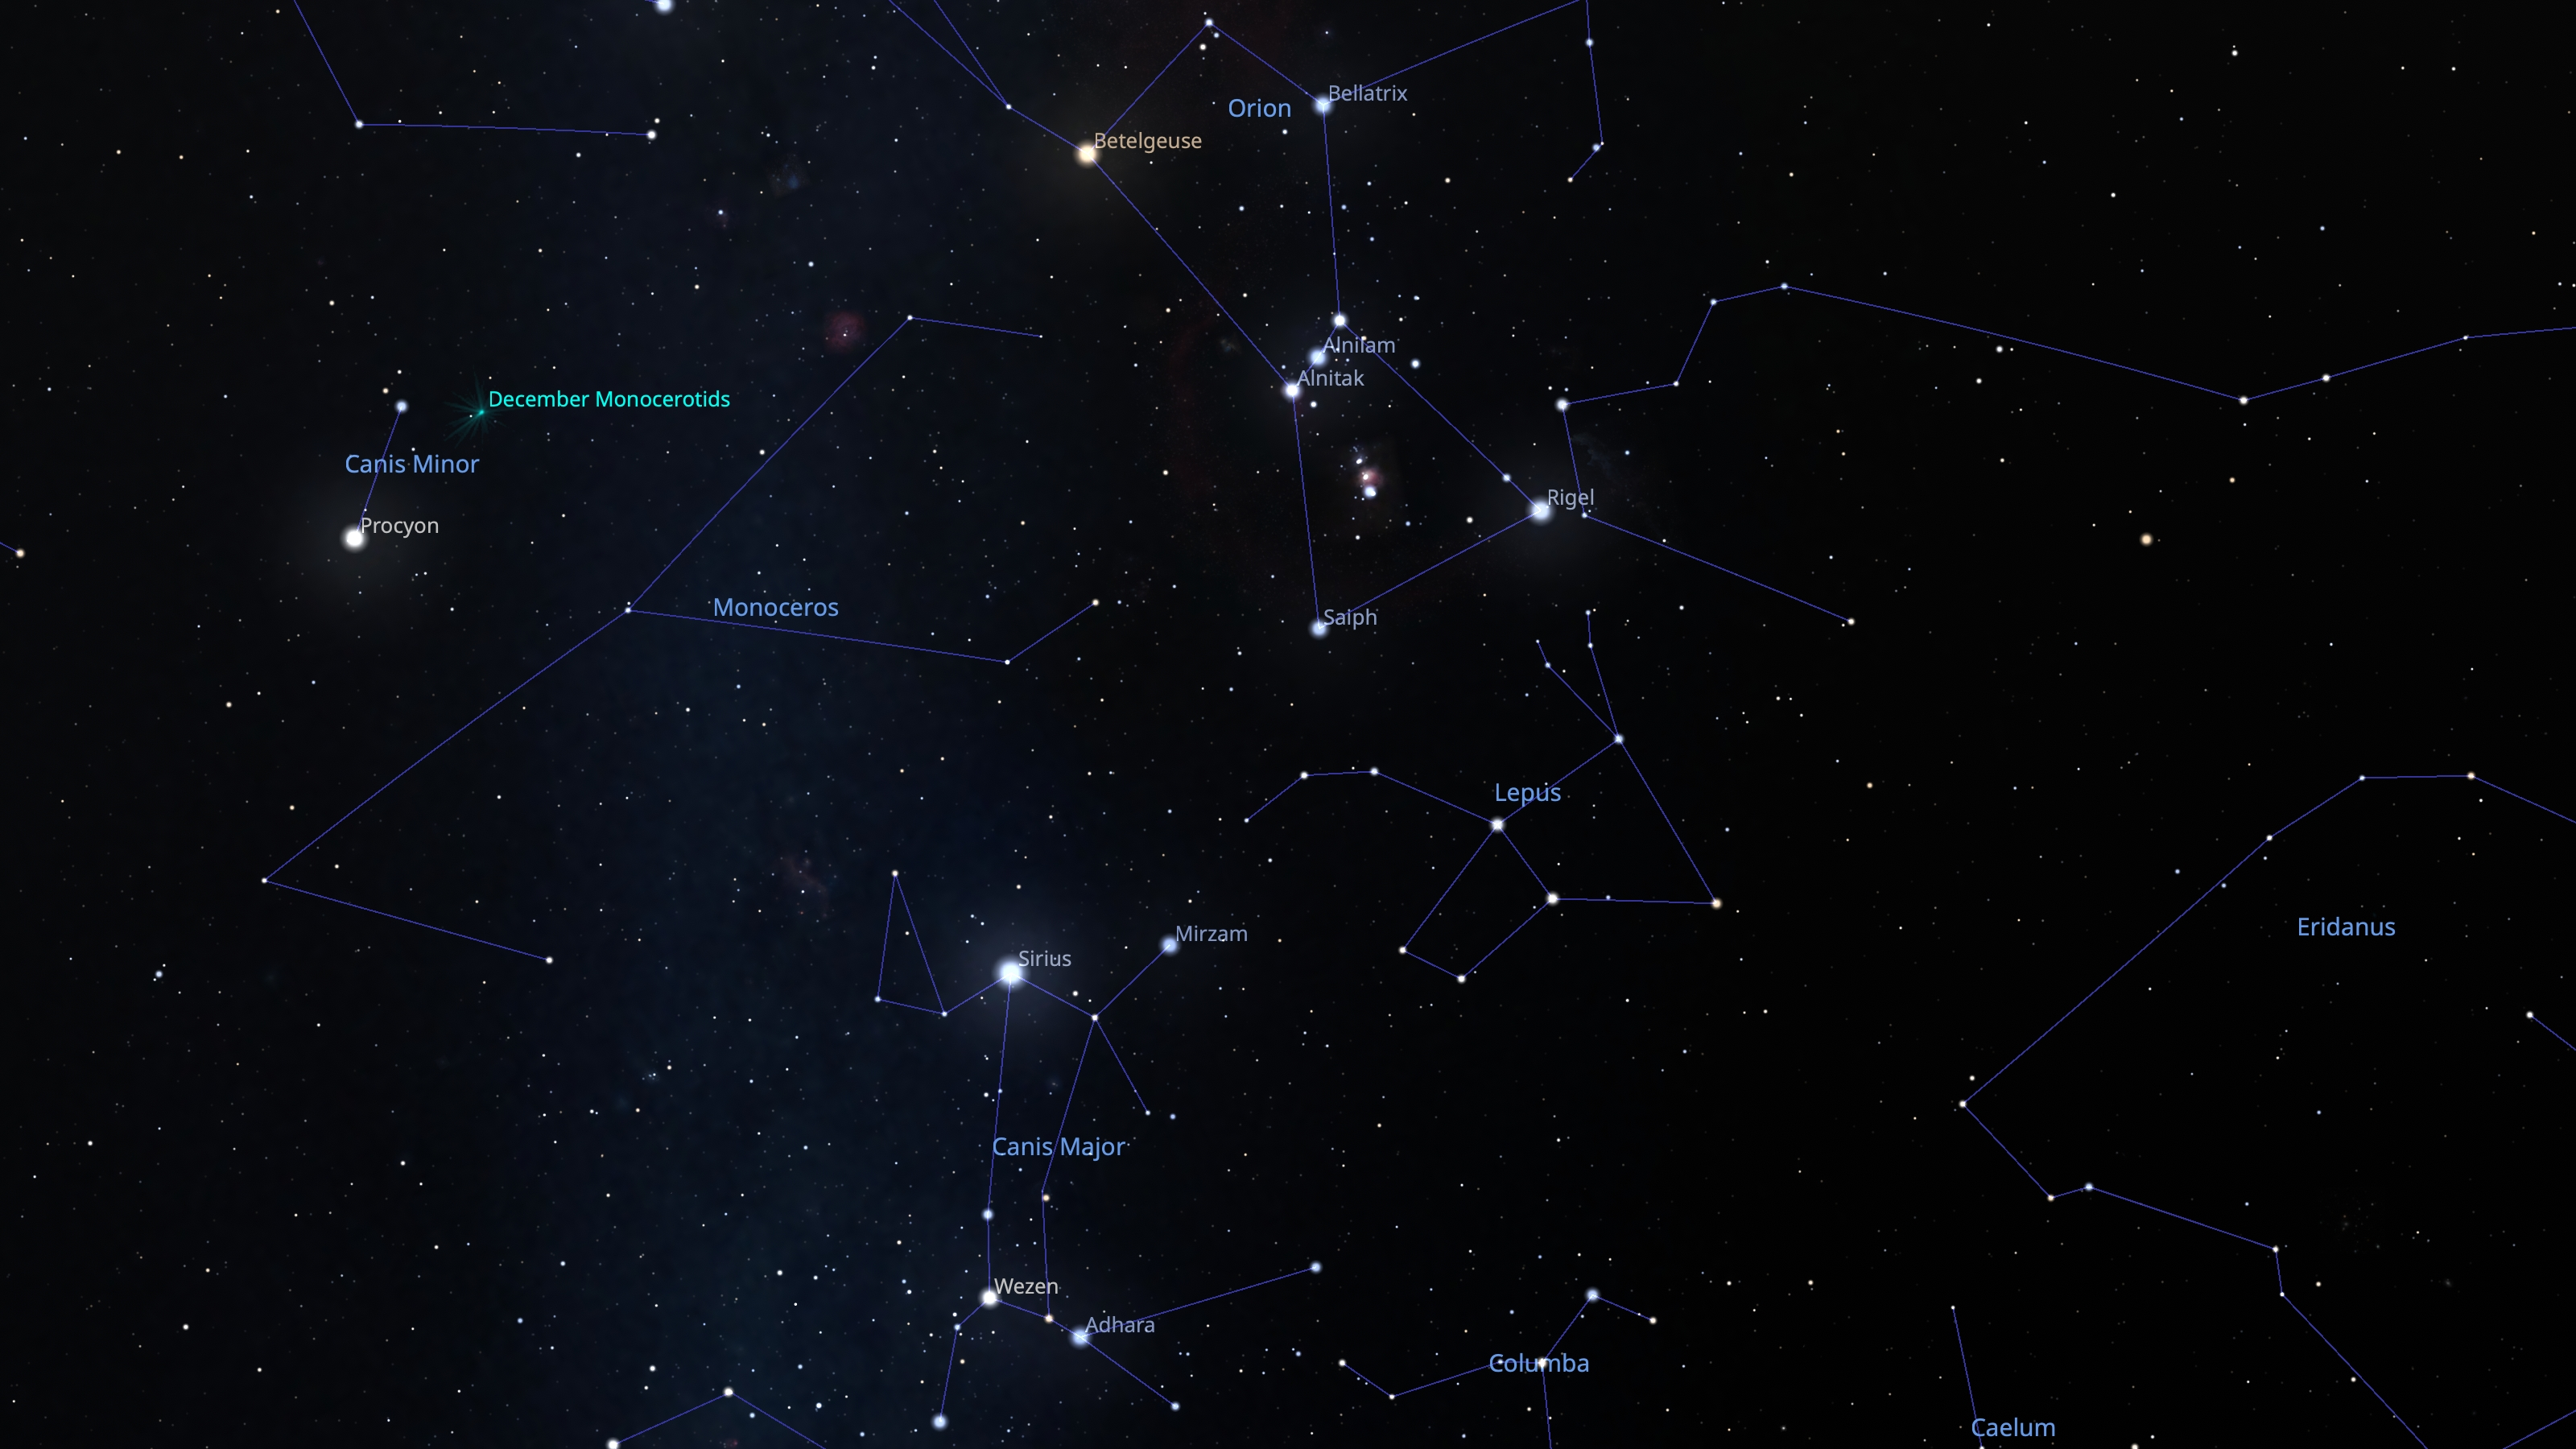